In [41]:
import numpy as np
import wandb
from tqdm import trange
from util.mnist.tools import *
from util.pickleInterface import *
from util.whatwhere.encoder import *
from util.whatwhere.decoder import *
from util.whatwhere.noise import *
from util.willshaw.memory import *
from util.willshaw.plot import *
from util.pytorch.tools import np_to_grid
from util.distribution import *
from util.basic_utils import mse_detailed
from util.whatwhere.description_encoding import *
from util.whatwhere.generate import *


In [42]:
def add_zero_noise_quiet(data, prob=0.1):
    """
    Adds noise to a binary dataset.
    Each 1 in the dataset will become a 0 with the given probability.

    @param data: 2-Dim csr matrix
    @param prob: probability of turning a 1 into a 0

    @return noisy: noisy version of the data
    """
    noisy = np.copy(data.toarray())

    for i in range(noisy.shape[0]):
        ones = np.argwhere(data[i] != 0)
        for j in range(len(ones)):
            if prob > random.random():
                noisy[i][ones[j]] = 0

    return csr_matrix(noisy)

In [62]:
def plot_sparsity_hist(codes, legend="", nbins=100, title="", flip=False):
    ones_per_code = np.sum(codes,axis=-1)
    if flip:
        plt.hist(ones_per_code, bins=nbins, density=True, label = legend, orientation='horizontal')
        plt.ylabel("number of active bits", fontsize=14)
        plt.xlabel("frequency", fontsize=14)
    else:
        plt.hist(ones_per_code, bins=nbins, density=True, label = legend)
        plt.xlabel("number of active bits", fontsize=14)
        plt.ylabel("frequency", fontsize=14)
        
    #plt.ylim([0,700])
    #plt.xlim([0,0.05])
    plt.title(title, fontsize=18)
    plt.legend(fontsize=14)

In [44]:
def plot_ret_recons(in_code, out_code, in_desc, out_desc):

    recon_in = recon_no_polar(in_code, features, 21, 20)
    recon_out = recon_no_polar(out_code, features, 21, 20)
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(recon_in.reshape(28,28),cmap=plt.cm.gray, vmin=0.0, vmax=1.0)
    axs[0].set_title(f"In bits: ({np.sum(in_desc)}|{np.sum(in_code)})")
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    

    axs[1].imshow(recon_out.reshape(28,28), cmap=plt.cm.gray, vmin=0.0, vmax=1.0)
    axs[1].set_title(f"Out bits: ({np.sum(out_desc)}|{np.sum(out_code)})")
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    plt.show()

In [45]:
def plot_mnist_code(code, save=False, title="output"):

    recon_in = recon_no_polar(code, features, 21, 20)
    plt.imshow(recon_in.reshape(28,28),cmap=plt.cm.gray, vmin=0.0, vmax=1.0)
    plt.xticks([])
    plt.yticks([])
    
    if save:
        plt.savefig(f"img/gens/iterative/{title}.png",bbox_inches='tight', transparent="True", pad_inches=0)
    else:
        plt.show()

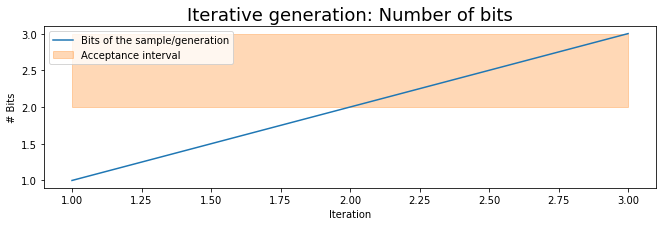

In [46]:
def plot_sparsity_ev(l_code_s=[1,2,3], code_m=2, code_M=3):
    x = np.arange(len(l_code_s))
    plt.plot(x+1, l_code_s, label="Bits of the sample/generation")
    plt.fill_between(x+1, code_m, code_M, color='C1', alpha=0.3, label="Acceptance interval")
    plt.title("Iterative generation: Number of bits", fontsize=18)
    plt.xlabel("Iteration")
    plt.ylabel("# Bits")
    plt.tight_layout()
    plt.legend()
    fig = plt.gcf()
    fig.set_size_inches(10, 3)
    plt.show()


plot_sparsity_ev()

In [47]:
""" Code generation parameters """
rng = np.random.RandomState(0)  # reproducible
K = 20
Q = 21
n_epochs = 5
b = 0.8
wta = True
Fs = 2
T_what = 0.75

""" load mnist """
imgs, lbls, tst_imgs, tst_lbls = read_mnist(n_train=60000)
I = imgs.shape[1]
J = imgs.shape[2]

""" generate codes """
features = compute_features(imgs, lbls, K, Fs, rng, n_epochs, b, verbose=False)
codes, polar_params = compute_codes(
    imgs,
    K,
    Q,
    features,
    T_what,
    wta,
    n_epochs,
    b,
    Fs,
    verbose=False,
    set="trn"
)

code_size = codes.shape[1]

In [48]:
n_stored = 30000
""" Create clean desCodes (patterns to store in the memory) """
nxh_x = 882
nxh_Pc = 0.1
nxh_Pr = 0.0

descs = noisy_x_hot_encoding(lbls[:n_stored], nxh_x, nxh_Pc, nxh_Pr)
desCodes = join(descs[:n_stored], codes[:n_stored])
desc_size = descs.shape[1]

KeyboardInterrupt: 

In [ ]:
""" Store desCodes in a WN """
wn_desCodes = AAWN(desc_size + code_size)
wn_desCodes.store(desCodes[:n_stored])

In [ ]:
""" Retrive The descodes"""
ret_desCodes = wn_desCodes.retrieve(desCodes[:n_stored])

in_descs, in_codes = separate(desCodes, desc_size)
out_descs, out_codes = separate(ret_desCodes, desc_size)

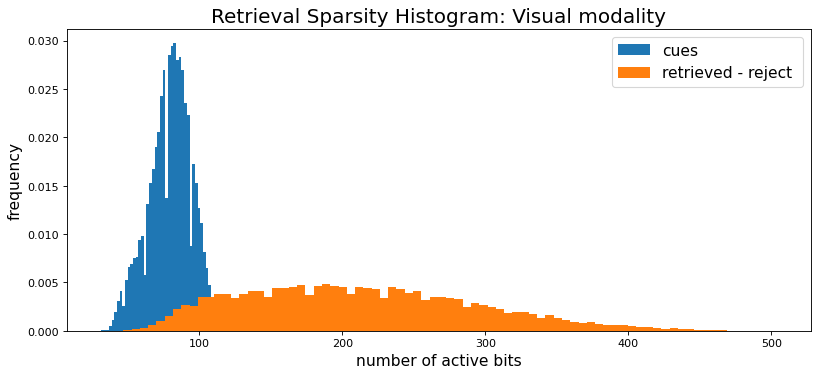

In: 79.57 (14.95)
Out: 211.77 (80.68)


In [65]:
""" Visualize how the sparsity of normal retrieval works"""
from matplotlib.pyplot import figure
figure(figsize=(12, 5), dpi=80)
plot_sparsity_hist(in_codes.toarray(), "cues", title="Sparsity of retrieval: Visual modality", nbins=50)
plot_sparsity_hist(out_codes.toarray(), "retrieved - reject ", title="Retrieval Sparsity Histogram: Visual modality",nbins=80)
plt.savefig("img/gens/sparsity_hist2.png", dpi=100)
plt.show()

in_codes_mean = avg_bits_per_code(in_codes)
in_codes_std = std_bits_per_code(in_codes)

out_codes_mean = avg_bits_per_code(out_codes)
out_codes_std = std_bits_per_code(out_codes)

print(f"In: {in_codes_mean:.2f} ({in_codes_std:.2f})")
print(f"Out: {out_codes_mean:.2f} ({out_codes_std:.2f})")

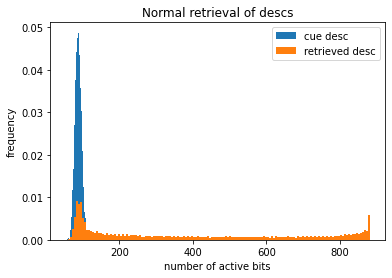

In: 88.27 (8.96)
Out: 396.72 (284.75)


In [ ]:
plot_sparsity_hist(in_descs, "cue desc", title="Normal retrieval of descs", nbins=80)
plot_sparsity_hist(out_descs, "retrieved desc", title="Normal retrieval of descs", nbins=150)
plt.show()

in_descs_mean = avg_bits_per_code(csr_matrix(in_descs))
in_descs_std = std_bits_per_code(in_descs)

out_descs_mean = avg_bits_per_code(csr_matrix(out_descs))
out_descs_std = std_bits_per_code(out_descs)

print(f"In: {in_descs_mean:.2f} ({in_descs_std:.2f})")
print(f"Out: {out_descs_mean:.2f} ({out_descs_std:.2f})")

In [49]:
""" Method to generate one pattern at a time (sampling from class distribution of codes)"""
def generate_from_sample(dists, c=0, Pdel_codes=0.75, plot=True):

    in_lbl = np.array([c])
    in_desc = noisy_x_hot_encoding(in_lbl, nxh_x, nxh_Pc, nxh_Pr)

    in_code = sample_from_dists(dists, in_lbl)
    in_code = add_zero_noise_quiet(in_code, Pdel_codes)
    
    
    in_desCode = join(in_desc, in_code)
    out_desCode = wn_desCodes.retrieve(in_desCode)

    out_desc, out_code = separate(out_desCode, desc_size)

    if plot:
        #plot_mnist_code(in_code)
        #print(np.sum(out_code))
        #plot_mnist_code(out_code)
        plot_ret_recons(in_code, out_code, in_desc.flatten(), out_desc.flatten())
    return out_code


In [50]:
dists = compute_dists(codes, lbls)

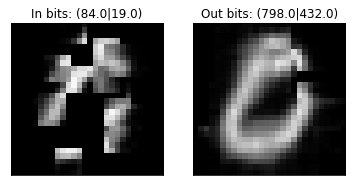

In [51]:
gen = generate_from_sample(dists, 0, Pdel_codes=0.75, plot=True)

In [52]:
n_classes=10
n_exs=3

gen_lbls = create_gen_lbls(n_classes, n_exs, transpose=False)

In [53]:
import torchvision.transforms.functional as F
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

C:\Users\rodrigo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


216.76666666666668


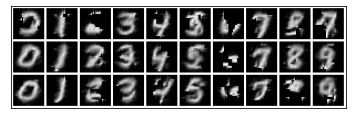

In [54]:
""" Generate from sample """
Pdel = 0.75

gen_codes = csr_matrix((len(gen_lbls), code_size))
for i in range(len(gen_lbls)):
    l = gen_lbls[i]
    gen_codes[i] = generate_from_sample(dists, l, Pdel_codes=Pdel, plot=False)
print(avg_bits_per_code(gen_codes))
recons = recon_no_polar(gen_codes, features, 21, 20)
show(np_to_grid(recons))

In [60]:
def trial_and_error_generate(dists, c, Pdel, num_tries=10, m=200, M=300):
    for i in range(num_tries):

        gen_code = generate_from_sample(dists, c, Pdel_codes=Pdel, plot=False)
        gen_bits = np.sum(gen_code)

        if gen_bits > m and gen_bits < M:
            return gen_code, i

    return gen_code, i

C:\Users\rodrigo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


average number of tries:  4.633333333333334


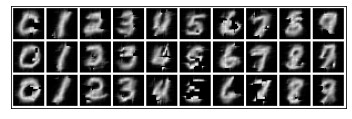

In [61]:
""" Generate from sample - trial and error """
Pdel = 0.75
m = 300
M = 400
num_tries = 10

gen_codes = csr_matrix((len(gen_lbls), code_size))
l_tries = []
for i in range(len(gen_lbls)):
    l = gen_lbls[i]
    gen_codes[i], tries = trial_and_error_generate(dists, l, Pdel, num_tries, m, M)
    l_tries.append(tries)
print("average number of tries: ", sum(l_tries)/len(l_tries))
recons = recon_no_polar(gen_codes, features, 21, 20)

show(np_to_grid(recons))

In [28]:
def iterative_generate(desc, code_sparsify = 20, increment=6, code_m=200, code_M=300, num_tries=10,  plot=0):

    l_code_s = []

    first_code = csr_matrix(np.zeros(codes[0].shape)) # empty visual modality
    
    in_desc = desc
    in_code = first_code


    for i in range(num_tries):
        in_desCode = join(in_desc, in_code)

        out_desCode = wn_desCodes.retrieve(in_desCode)
        out_desc, out_code = separate(out_desCode, desc_size)

        in_code_bits = np.sum(in_code)
        out_code_bits = np.sum(out_code)
        
        l_code_s.append(in_code_bits)
        l_code_s.append(out_code_bits)

        if plot == 1:
            plot_ret_recons(in_code, out_code, in_desc.flatten(), out_desc.flatten())
        if plot == 2:
            img_id = "gen_" + str(i)
            plot_mnist_code(in_code, save=True, title=img_id + "_in")
            plot_mnist_code(out_code, save=True, title=img_id + "_out")
        

        if (out_code_bits >= code_m and out_code_bits <= code_M):
            break
        else:
            Pdel_code = 1 - code_sparsify / out_code_bits
            if Pdel_code < 1.0:
                out_code = add_zero_noise_quiet(out_code, Pdel_code)
            
            in_code = out_code
            code_sparsify += increment
    
    return out_code, l_code_s
    

In [ ]:
""" c = 0 # class
initial_sparsity = 40
final_sparsity = 80
n_iter = 10
inc = int((final_sparsity - initial_sparsity)/n_iter)

code_m = 300
code_M = 400
random.seed(2)
 """


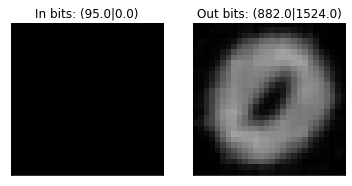

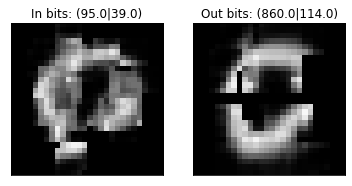

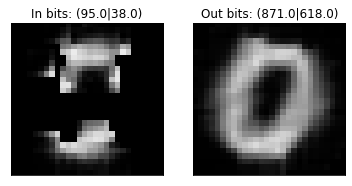

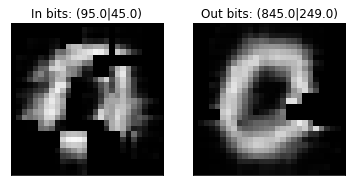

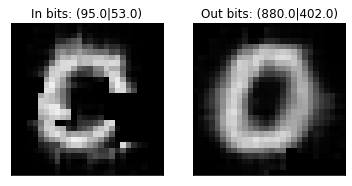

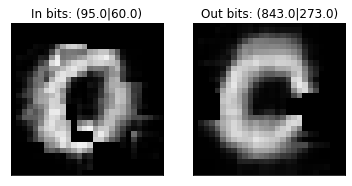

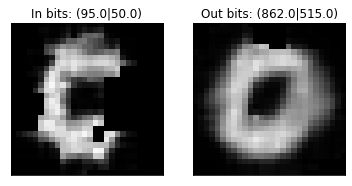

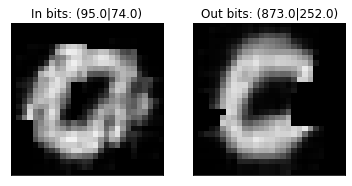

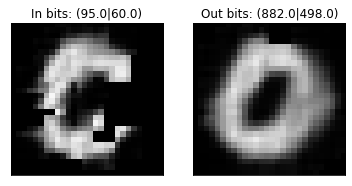

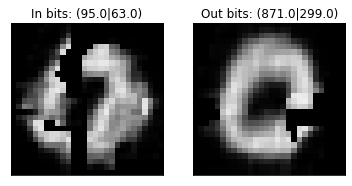

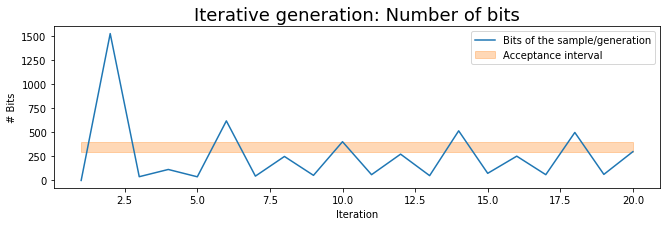

In [60]:
c = 0 # class
initial_sparsity = 40
final_sparsity = 80
n_iter = 10
inc = int((final_sparsity - initial_sparsity)/n_iter)

code_m = 300
code_M = 400
random.seed(7)



gen_desc = noisy_x_hot_encoding(np.array([c]), nxh_x, nxh_Pc, nxh_Pr)

_, l_code_s = iterative_generate(gen_desc, initial_sparsity, inc, code_m, code_M, n_iter,  plot=1)
plot_sparsity_ev(l_code_s, code_m, code_M)

In [ ]:
""" initial_sparsity = 20
final_sparsity = 60
n_iter = 50
inc = int((final_sparsity - initial_sparsity)/n_iter)

code_m = 400
code_M = 500
random.seed(0)
 """

In [93]:
n_classes=10
n_exs=5

gen_lbls = create_gen_lbls(n_classes, n_exs, transpose=False)

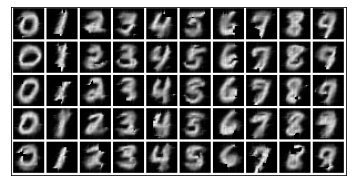

In [102]:
""" Generate Grid """
initial_sparsity = 20
final_sparsity = 60
n_iter = 10
inc = int((final_sparsity - initial_sparsity)/n_iter)

code_m = 400
code_M = 500
random.seed(0)

gen_codes = csr_matrix((len(gen_lbls), code_size))
for i in range(len(gen_lbls)):
    l = gen_lbls[i]
    gen_desc = noisy_x_hot_encoding(np.array([l]), nxh_x, nxh_Pc, nxh_Pr)
    gen_codes[i], _ = iterative_generate(gen_desc, initial_sparsity, inc, code_m, code_M, n_iter,  plot=False)

recons = recon_no_polar(gen_codes, features, 21, 20)

show(np_to_grid(recons))

In [66]:
"""pseudo code for thesis"""

def iterative_generation(description, sparsify_init = 20, sparsify_inc=6, accept=[200, 300], max_iter = 10):

    visual_modality = [0,...,0] # empty visual modality
    cue = description + visual_modality
    
    S = sparsify_init
    for i in range(max_iter):
        generation = wn_desCodes.retrieve(cue)
        if accept[0] < generation.num_bits < accept[1]:
            break
        else:
            Pdel = 1 - (S / generation.num_bits)
            cue.visual = sparsify(generation, P=Pdel)
            S += sparsify_inc
    
    return generation

SyntaxError: invalid syntax (Temp/ipykernel_2320/1118779245.py, line 10)